# Clustering using Normalized Compression Distance

## Preparations

In [91]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import math
from functools import reduce
sns.set()
%matplotlib inline
import os

### Read the data

In [92]:
#GRANULARITY = 'one_hour'
#GRANULARITY = 'thirty_min'
GRANULARITY = 'five_min'
#GRANULARITY = 'one_min'

IMAGES_DIR = 'images/clustering/'

PATH = 'data/cleaned/samples50/' + GRANULARITY + '/'
DIR_CONTENT = os.listdir(PATH)

In [93]:
column_names = list(map(lambda s: s.split('.')[0], DIR_CONTENT))

In [94]:
df = pd.DataFrame(columns=column_names)

In [95]:
for filename in DIR_CONTENT:
    _id = filename.split('.')[0]
    tmp_df = pd.read_csv(PATH + filename)
    df[_id] = tmp_df['heart_rate']

In [96]:
df.head(5)

,yyyyy_12,ggggg_4,eeeee_12,eeeee_13,xxxxx_8,yyyyy_13,yyyyy_11,eeeee_11,eeeee_10,yyyyy_10,...,xxxxx_3,eeeee_18,xxxxx_2,xxxxx_6,ttttt_3,ttttt_2,xxxxx_7,xxxxx_5,ttttt_1,xxxxx_4
0,0.000000,0.0,0.0,0.618519,0.0,0.0,0.000000,29.296296,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.183333,0.0,0.0,0.000000,14.210000,1.943333,0.0,...,0.0,3.366667,0.0,14.816667,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.863333,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,70.823333,0.0,0.0,0.0,0.0,0.0,0.0
3,14.123333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,65.673333,0.0,0.0,0.0,0.0,0.0,0.0
4,17.566667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,4.870000,0.0,...,0.0,0.000000,0.0,64.916667,0.0,0.0,0.0,0.0,0.0,0.0


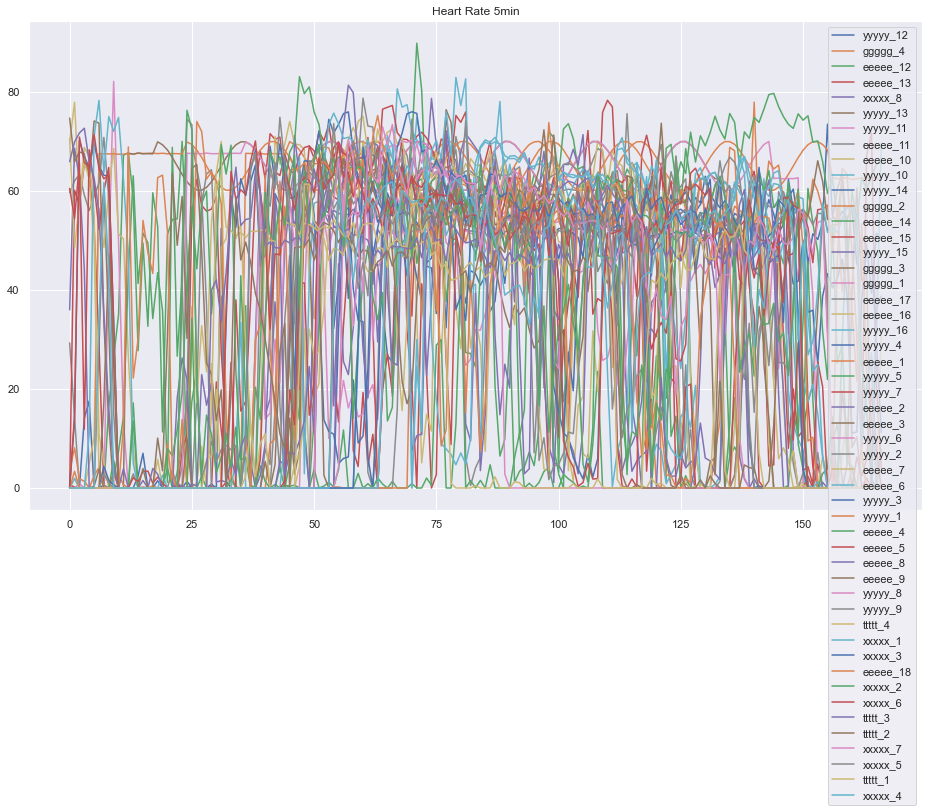

In [97]:
ax = df.plot(legend=True, title="Heart Rate 5min", figsize=(16,9))
fig = ax.get_figure()
#fig.savefig('/tmp/foo.png') # TODO

### Normalize the data

In [98]:
_mean = df.mean()
_std = df.std()

In [99]:
dfn = (df - _mean) / _std

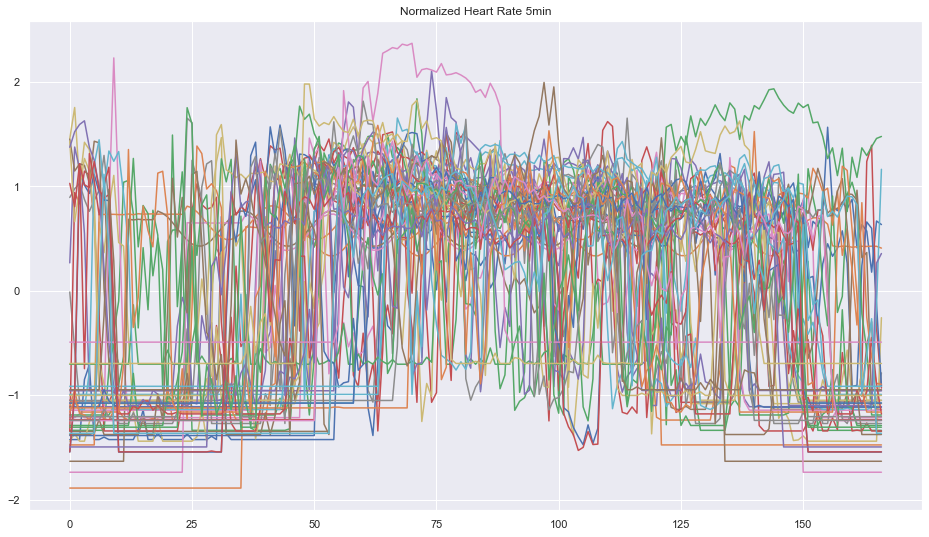

In [100]:
axn = dfn.plot(legend=False, title="Normalized Heart Rate 5min", figsize=(16,9))
fign = axn.get_figure()

## Calculate NCD

In [101]:
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/Current/Resources'

import time
import numpy
import rpy2
import rpy2.robjects.numpy2ri

from rpy2.robjects.packages import importr
rpy2.robjects.numpy2ri.activate()

from rpy2.robjects.packages import STAP

In [102]:
Rsession = rpy2.robjects.r
tsclust = importr('TSclust')

In [103]:
dfnt = dfn.transpose()

In [104]:
np_dfnt = dfnt.to_numpy()

In [105]:
r_ncd_matrix = tsclust.diss(np_dfnt , "NCD")

In [106]:
mfunc = 'mat <- function(dobj){return(as.matrix(dobj))}'
mat = STAP(mfunc, "mat")
ncd_matrix = numpy.array(mat.mat(r_ncd_matrix))

In [107]:
ncd_matrix[0]

array([0.        , 0.94271845, 0.92524272, 0.93883495, 0.91456311,
       0.92135922, 0.91941748, 0.92330097, 0.93817204, 0.9368932 ,
       0.93009709, 0.94757282, 0.9352381 , 0.92417062, 0.93980583,
       0.95436893, 0.94563107, 0.92038835, 0.91941748, 0.95048544,
       0.92999054, 0.92092575, 0.93883495, 0.93300971, 0.91359223,
       0.92912621, 0.93398058, 0.92427184, 0.91456311, 0.92264151,
       0.94563107, 0.91941748, 0.92265193, 0.92366412, 0.9490161 ,
       0.94062205, 0.97572816, 0.92395437, 0.91941748, 0.93203883,
       0.92815534, 0.9223301 , 0.93365385, 0.92      , 0.92427184,
       0.92621359, 0.91650485, 0.93009709, 0.9407767 , 0.92038835])

## Create Clusters

In [108]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from validclust.indices import dunn

from collections import defaultdict


In [109]:
cvi_lists = defaultdict(list)

for nbr_clusters in range(2, 21):
    tmp_model = KMeans(n_clusters=nbr_clusters, random_state=42)
    tmp_model.fit(ncd_matrix)
    tmp_cluster_labels = tmp_model.labels_
    
    sil_score = silhouette_score(ncd_matrix, tmp_cluster_labels)
    cvi_lists['sil'].append((nbr_clusters, sil_score))
    
    db_score = davies_bouldin_score(ncd_matrix, tmp_cluster_labels)
    cvi_lists['db'].append((nbr_clusters, db_score))
    
    dunn_score = dunn(ncd_matrix, tmp_cluster_labels)
    cvi_lists['dunn'].append((nbr_clusters, dunn_score))
    
    ch_score = calinski_harabasz_score(ncd_matrix, tmp_cluster_labels)
    cvi_lists['ch'].append((nbr_clusters, ch_score))
    
    
    

In [110]:
cvi_lists

defaultdict(list,
            {'sil': [(2, 0.04284703409490974),
              (3, 0.011627230826023205),
              (4, 0.003313210618250769),
              (5, 0.004854359674316575),
              (6, 0.001274118955469421),
              (7, 0.00284479718767997),
              (8, 0.006362018042765369),
              (9, 0.002375611315026861),
              (10, 0.0027081557280538766),
              (11, 0.005439907327620999),
              (12, 0.003279384939479181),
              (13, 0.000870417936617062),
              (14, 0.0019442142105038371),
              (15, 0.003815172926048622),
              (16, 0.0010441751104581834),
              (17, 0.0035764351931729136),
              (18, 0.0024521536078929325),
              (19, 0.0025444842363749574),
              (20, 0.0016251691910349345)],
             'db': [(2, 3.207085755489752),
              (3, 4.199410326037946),
              (4, 4.572975084391988),
              (5, 3.9916701609511813),
              (6, 3.

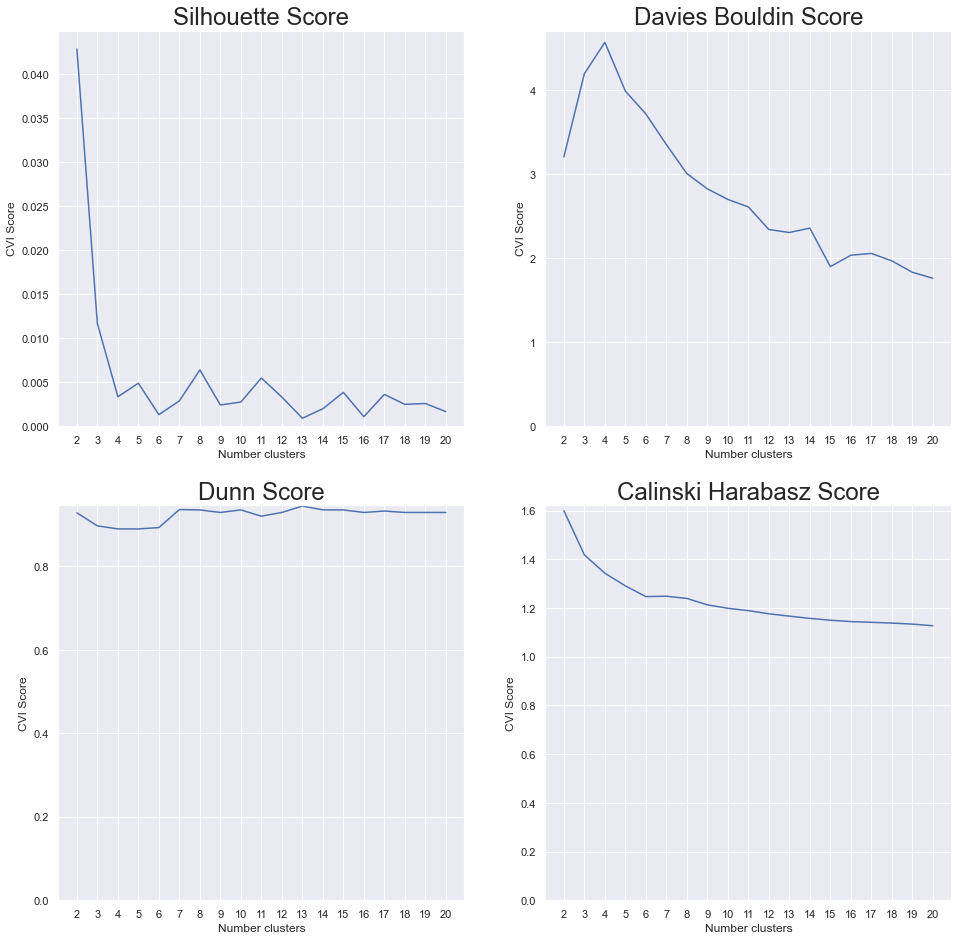

In [112]:
fig, axs = plt.subplots(2, 2, figsize=(16,16))

plt.setp(axs, xticks=list(range(2,21)))

x_sil, y_sil = list(zip(*cvi_lists['sil']))
axs[0][0].plot(x_sil, y_sil)
axs[0][0].set_ylim(0, )
axs[0][0].set_title('Silhouette Score', size=24)
axs[0][0].set_xlabel('Number clusters')
axs[0][0].set_ylabel('CVI Score')

x_db, y_db = list(zip(*cvi_lists['db']))
axs[0][1].plot(x_db, y_db)
axs[0][1].set_ylim(0, )
axs[0][1].set_title('Davies Bouldin Score', size=24)
axs[0][1].set_xlabel('Number clusters')
axs[0][1].set_ylabel('CVI Score')

x_dunn, y_dunn = list(zip(*cvi_lists['dunn']))
axs[1][0].plot(x_dunn, y_dunn)
axs[1][0].set_ylim(0, )
axs[1][0].set_title('Dunn Score', size=24)
axs[1][0].set_xlabel('Number clusters')
axs[1][0].set_ylabel('CVI Score')


x_ch, y_ch = list(zip(*cvi_lists['ch']))
axs[1][1].plot(x_ch, y_ch)
axs[1][1].set_ylim(0, )
axs[1][1].set_title('Calinski Harabasz Score', size=24)
axs[1][1].set_xlabel('Number clusters')
axs[1][1].set_ylabel('CVI Score')



#fig.savefig(IMAGES_DIR + 'ncd_cvis.png')

In [113]:
from optimizer import get_cvi_combination

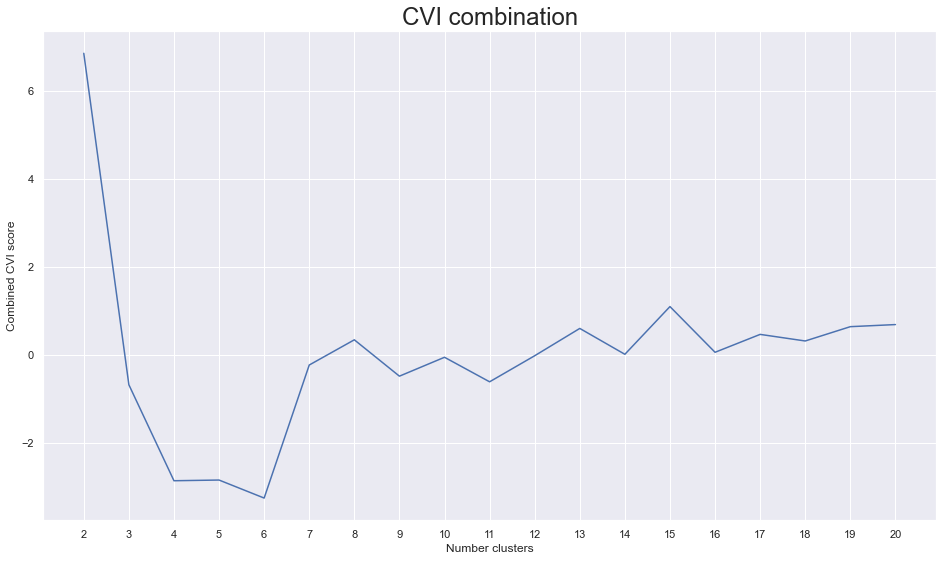

In [223]:
y = get_cvi_combination(y_sil, y_dunn, y_db, y_ch)

fig = plt.figure(figsize=(16,9))
plt.plot(x_ch, y)
ax = fig.gca()
plt.setp(ax, xticks=list(range(2,21)))
ax.set_title("CVI combination", size=24)
ax.set_xlabel('Number clusters')
ax.set_ylabel('Combined CVI score')
#fig.savefig(IMAGES_DIR + 'cvi_combination_ncd.png')

## Display Clusters

In [213]:
number_clusters = 8

In [214]:
model = KMeans(n_clusters=number_clusters, random_state=42)

In [215]:
model.fit(ncd_matrix)

KMeans(random_state=42)

In [216]:
cluster_labels = model.labels_
cluster_labels

array([3, 6, 7, 1, 4, 5, 3, 5, 1, 4, 3, 6, 1, 7, 4, 6, 6, 5, 5, 4, 0, 1,
       4, 3, 4, 7, 4, 4, 4, 1, 3, 4, 7, 3, 5, 5, 2, 1, 4, 4, 4, 5, 1, 0,
       3, 4, 3, 3, 4, 7], dtype=int32)

In [217]:
cluster_names = defaultdict(list)
for i, cid in enumerate(cluster_labels):
    c_name = dfnt.index[i]
    cluster_names[cid].append(c_name)

In [218]:
cluster_names

defaultdict(list,
            {3: ['yyyyy_12',
              'yyyyy_11',
              'yyyyy_14',
              'yyyyy_7',
              'yyyyy_3',
              'eeeee_5',
              'ttttt_3',
              'xxxxx_7',
              'xxxxx_5'],
             6: ['ggggg_4', 'ggggg_2', 'ggggg_3', 'ggggg_1'],
             7: ['eeeee_12', 'eeeee_15', 'eeeee_3', 'eeeee_4', 'xxxxx_4'],
             1: ['eeeee_13',
              'eeeee_10',
              'eeeee_14',
              'eeeee_1',
              'eeeee_6',
              'yyyyy_9',
              'xxxxx_2'],
             4: ['xxxxx_8',
              'yyyyy_10',
              'yyyyy_15',
              'yyyyy_16',
              'yyyyy_5',
              'eeeee_2',
              'yyyyy_6',
              'yyyyy_2',
              'eeeee_7',
              'yyyyy_1',
              'ttttt_4',
              'xxxxx_1',
              'xxxxx_3',
              'ttttt_2',
              'ttttt_1'],
             5: ['yyyyy_13',
              'eeeee

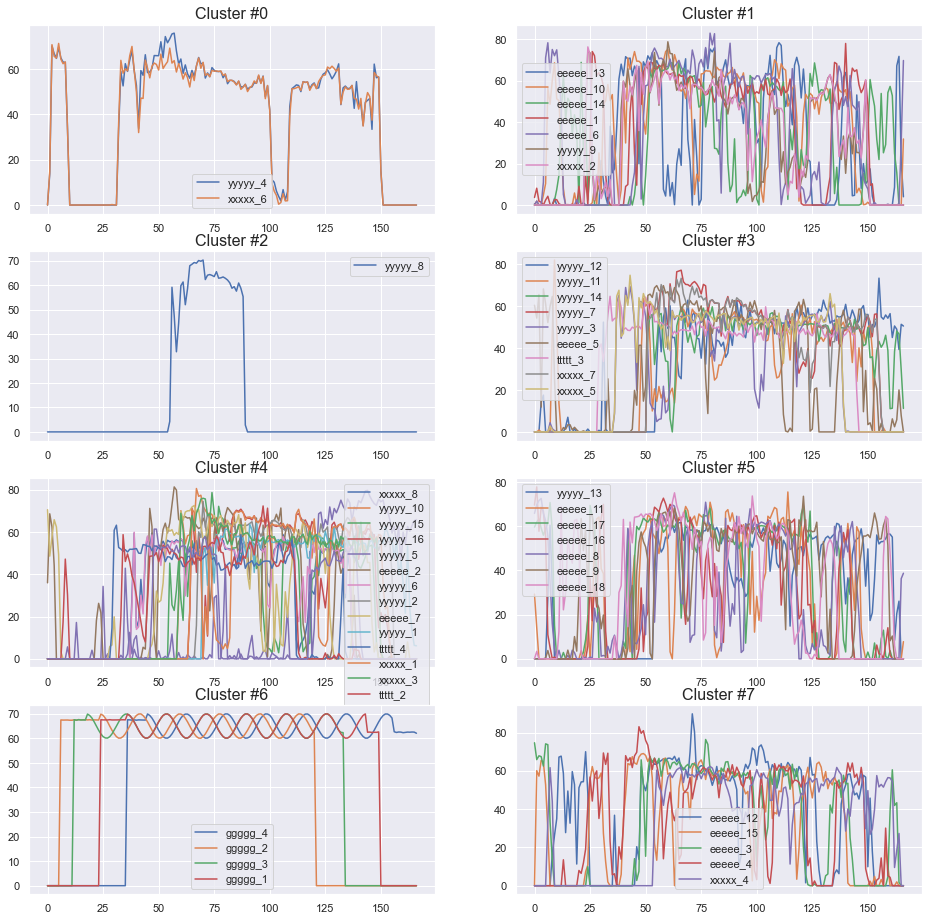

In [222]:
fig, axs = plt.subplots(4,2)

for cluster_id in range(len(cluster_names)):
    i = cluster_id % 2  # Column
    j = cluster_id // 2 # Row
    
    ax = axs[j][i]
    
    names = cluster_names[cluster_id]
    #ax = df[[*names]].plot(figsize=(16,9))
    df[[*names]].plot(ax=ax, figsize=(16,16), legend=True)
    ax.set_title(f"Cluster #{cluster_id}", size=16)

#fig.savefig(IMAGES_DIR + 'ncd_clustering.png')
    